In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette1 = sns.color_palette()
palette2 = sns.color_palette("hls",3)
palette_greys = sns.color_palette("Greys",5)

In [2]:
def rename(df):
    df['modelname_old'] = df['modelname']
    df['modelname'] = df['modelname'].replace('least_squares', 'K-means: Least squares \n(sign-flipped eigenvectors)')
    df['modelname'] = df['modelname'].replace('diametrical', 'K-means: Diametrical')
    df['modelname'] = df['modelname'].replace('complex_diametrical', 'K-means: Complex diametrical')
    df['modelname'] = df['modelname'].replace('grassmann', 'K-means: Grassmann')
    df['modelname'] = df['modelname'].replace('weighted_grassmann', 'K-means: Weighted Grassmann')
    df['modelname'] = df['modelname'].replace('Watson', 'Mixture: Watson')
    df['modelname'] = df['modelname'].replace('Complex_Watson', 'Mixture: Complex Watson')
    df['modelname'] = df['modelname'].replace('ACG', 'Mixture: ACG')
    df['modelname'] = df['modelname'].replace('Complex_ACG', 'Mixture: Complex ACG')
    df['modelname'] = df['modelname'].replace('MACG', 'Mixture: MACG')
    df['modelname'] = df['modelname'].replace('SingularWishart', 'Mixture: Singular Wishart')
    df['modelname'] = df['modelname'].replace('Normal', 'Mixture: Gaussian')
    df['modelname'] = df['modelname'].replace('Complex_Normal', 'Mixture: Complex Gaussian')
    
# if column LR doesnt exist, make it with zeros
    if 'LR' not in df.columns:
        df['LR'] = 0
    if 'HMM' not in df.columns:
        df['HMM'] = False

    names = [] #without the Kmeans or Mixture or HMM
    names2 = [] #with
    group = []
    for i in range(len(df)):
        if 'Watson' in df['modelname'][i]:
            add_rank = ''
        else:
            add_rank = ' rank='+str(df['rank'][i])
        if df['HMM'][i]:
            add_HMM = 'HMM: '
        else:
            add_HMM = ''
        if 'Mixture' in df['modelname'][i]:
            names.append(df['modelname'][i][8:]+add_rank)
            if df['HMM'][i]:
                names2.append(add_HMM + df['modelname'][i][8:]+add_rank)
            else:
                names2.append(add_HMM + df['modelname'][i]+add_rank)
        else:
            names.append(df['modelname'][i][:8])
            names2.append(df['modelname'][i])
        if df['LR'][i]==0:
            group.append('EM')
        elif df['LR'][i]==0.1 and not df['HMM'][i]:
            group.append('Torch')
        elif df['LR'][i]==0.1 and df['HMM'][i]:
            group.append('HMM')
            
    df['names'] = names
    df['names2'] = names2
    df['group'] = group
    return df

In [3]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'
df1 = pd.read_csv(data_folder+'narrowband_phase_controlled_least_squares.csv')
df2 = pd.read_csv(data_folder+'narrowband_phase_controlled_diametrical.csv')
df3 = pd.read_csv(data_folder+'narrowband_phase_controlled_complex_diametrical.csv')
df4 = pd.read_csv(data_folder+'narrowband_phase_controlled_grassmann.csv')
df5 = pd.read_csv(data_folder+'narrowband_phase_controlled_weighted_grassmann.csv')
df_kmeans = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df_kmeans = rename(df_kmeans)

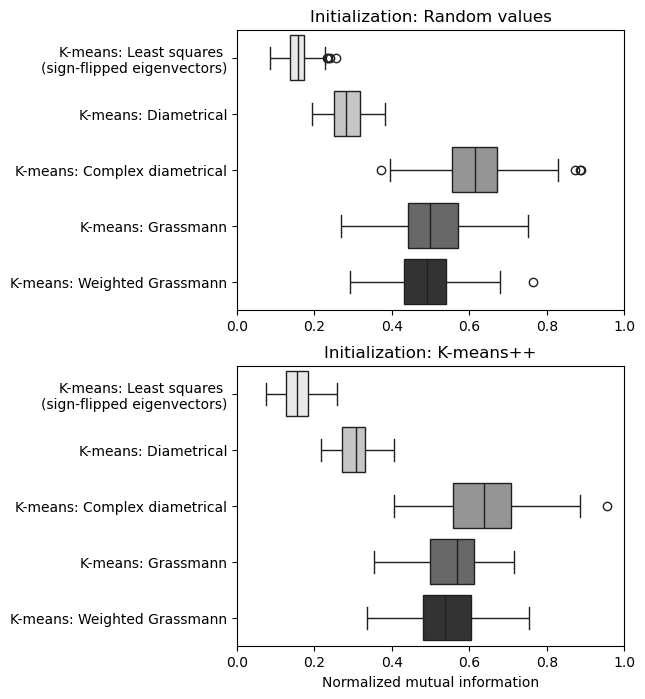

In [4]:
fig,axs = plt.subplots(2,1,figsize=(5,8), sharey=True)
df_tmp = df_kmeans[(df_kmeans['init_method']=='uniform')]
sns.boxplot(x='train_NMI', y='names2', data=df_tmp, ax=axs[0], palette=palette_greys,hue='names2')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title('Initialization: Random values')
axs[0].set_xlim([0,1])
sns.boxplot(x='train_NMI', y='names2', data=df_kmeans[df_kmeans['init_method']=='++'], ax=axs[1], palette=palette_greys,hue='names2')
axs[1].set_xlabel('Normalized mutual information')
axs[1].set_ylabel('')
axs[1].set_title('Initialization: K-means++')
axs[1].set_xlim([0,1])
fig.savefig('figures/torchvsEM_phase_narrowband_controlled_results_kmeans.pdf', bbox_inches='tight')

In [5]:
data_folder = '../data/results/torchvsEM_phase_controlled_results/'

df = pd.DataFrame()
for model in ['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal','Complex_Normal']:
    for init in ['random','Kmeans','Kmeansseg','ALL']:
        try:
            data = pd.read_csv(data_folder+'narrowband_phase_controlled_'+model+'_init'+init+'.csv')
        except:
            continue
        data = rename(data)
        if init == 'ALL':
            data['initialization'] = 'Consecutive \n rank'
        elif init == 'Kmeansseg':
            data['initialization'] = 'Analytical \n maximization'
        elif init == 'Kmeans':
            data['initialization'] = 'K-means'
        elif init == 'random':
            data['initialization'] = 'Random'

        # data['initialization'] = init
        df = pd.concat([df, data], ignore_index=True)

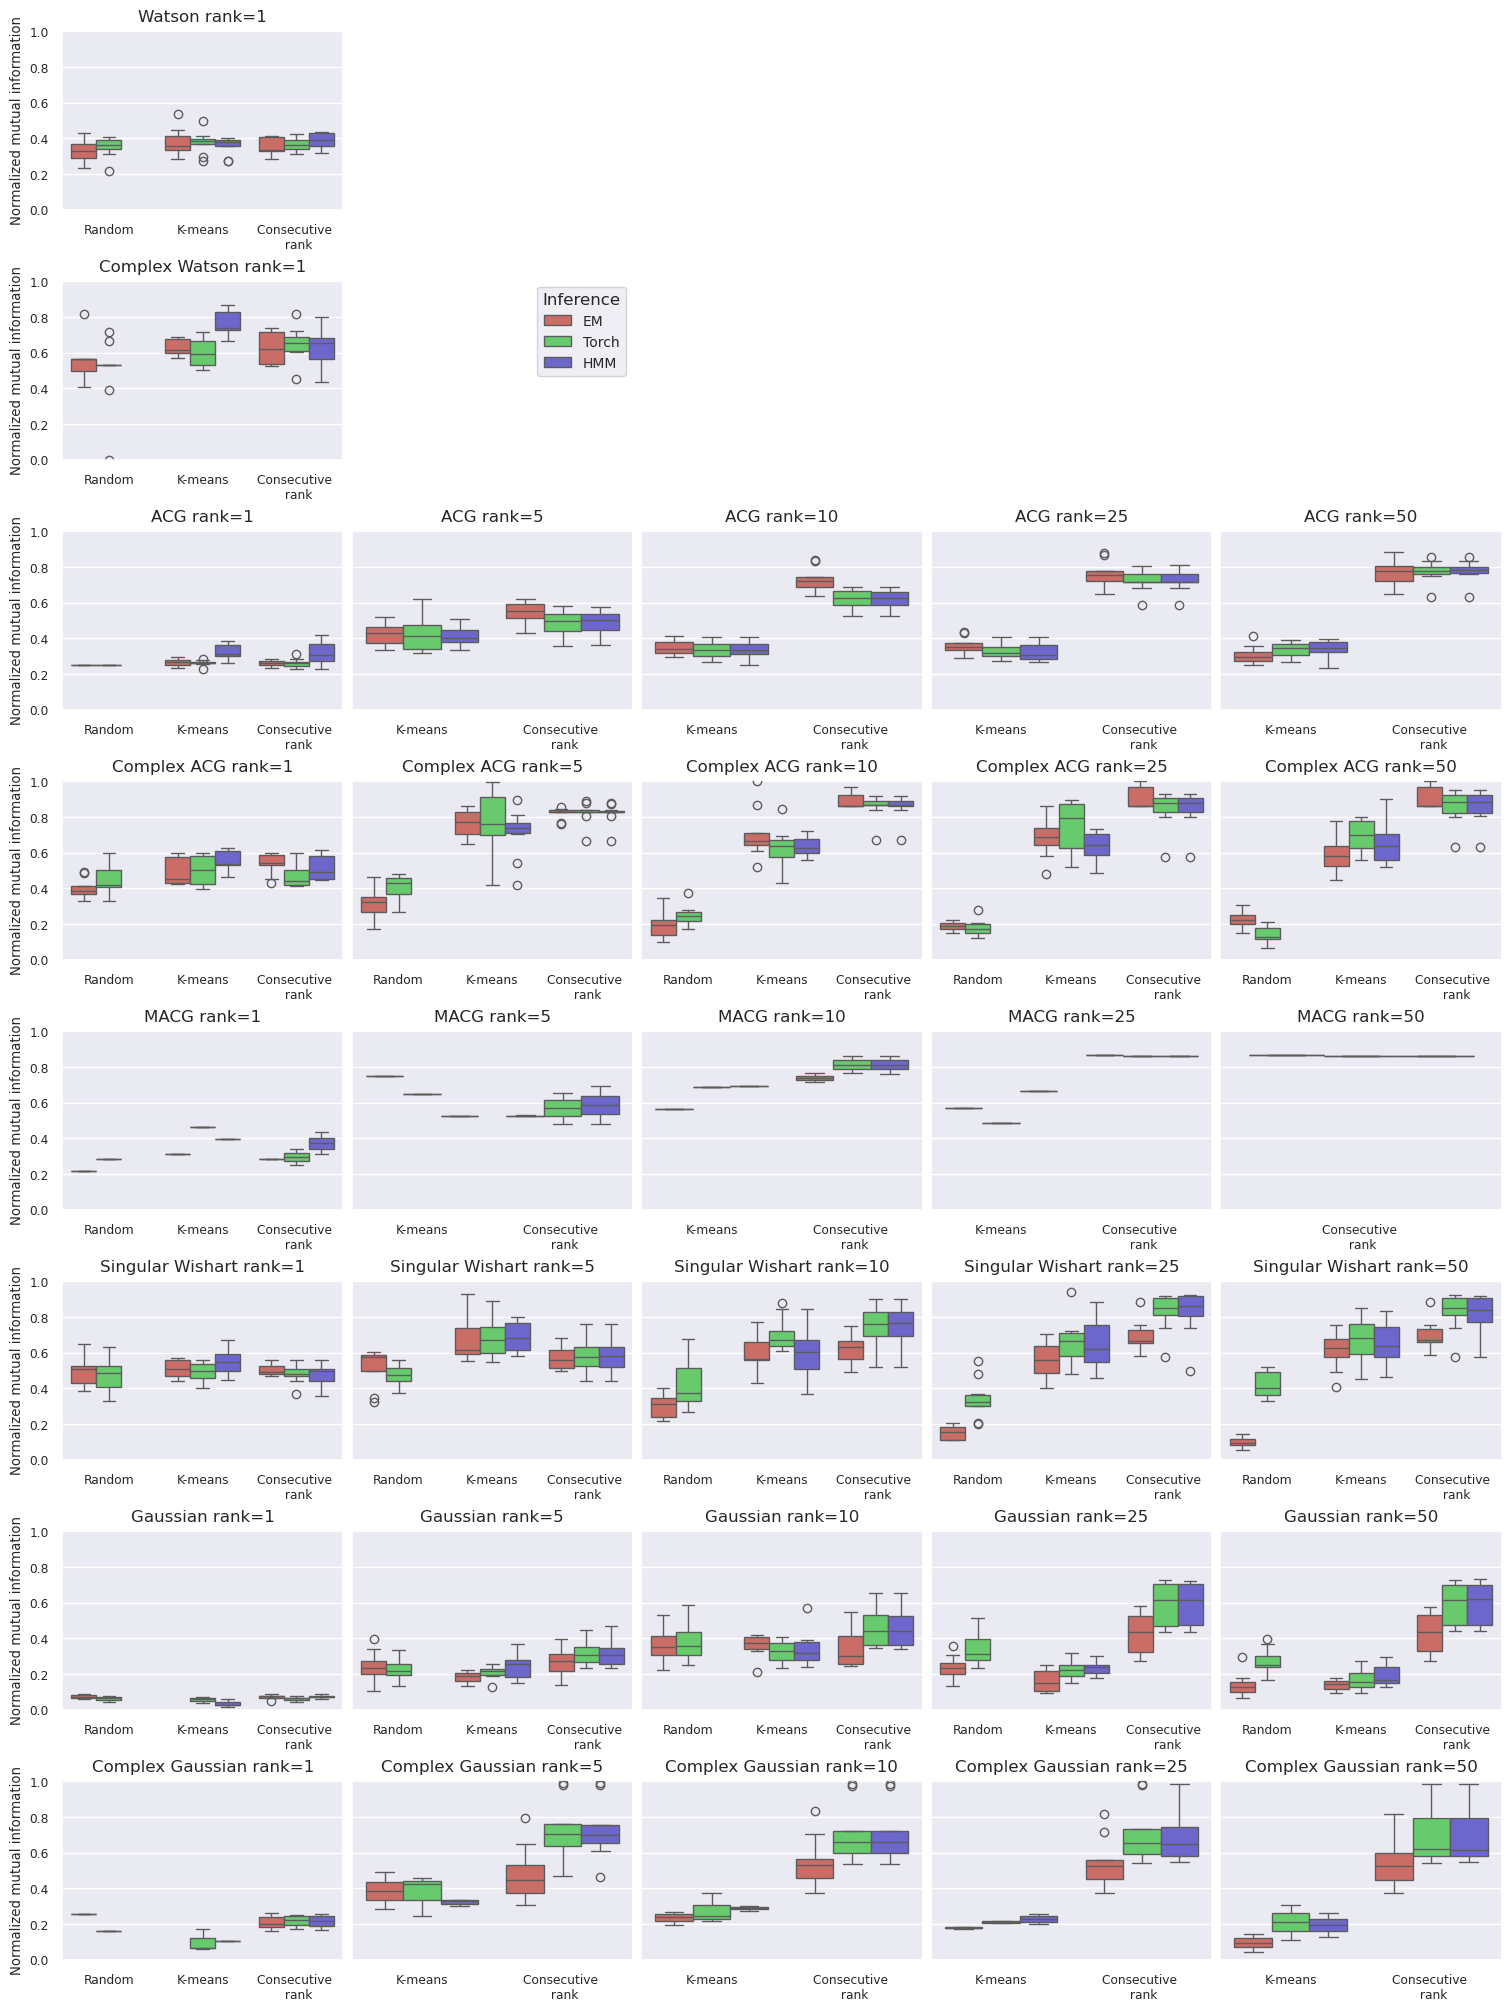

In [ ]:
sns.set(font_scale=0.8)
fig,axs = plt.subplots(8,5,figsize=(15,20), sharey=True,layout='constrained')
for i,models in enumerate(['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal','Complex_Normal']):
    for j,rank in enumerate([1,5,10,25,50]):
        if rank!=1 and models in ['Watson','Complex_Watson']:
            axs[i,j].axis('off')
            continue
        df0 = df[df['modelname_old']==models]
        df1 = df0[df0['rank']==rank]
        df1 = df1[df1['initialization']!='Analytical \n maximization']
        sns.boxplot(y='train_NMI', x='initialization',hue='group', data=df1, ax=axs[i,j], palette=palette2,legend=True)
        if i==0 and j==0:
            axs[1,1].legend(loc='upper right', fontsize=10, title='Inference', title_fontsize=12, handles=axs[i,j].get_legend_handles_labels()[0], labels=axs[i,j].get_legend_handles_labels()[1])
        if 'Complex' in models:
            title = models.replace('Complex_','Complex ')
        else:
            title = models
        if 'SingularWishart' in models:
            title = 'Singular Wishart'
        if 'Normal' in models:
            title = title.replace('Normal','Gaussian')
            
        axs[i,j].set_title(title+' rank='+str(rank), fontsize=12)
        axs[i,j].set_ylim([0,1.01])
        if j!=0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('Normalized mutual information')
        # if i!=3:
        axs[i,j].set_xlabel('')
        # if i!=0 or j!=0:
        axs[i,j].get_legend().remove()
        # axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results.pdf', bbox_inches='tight')

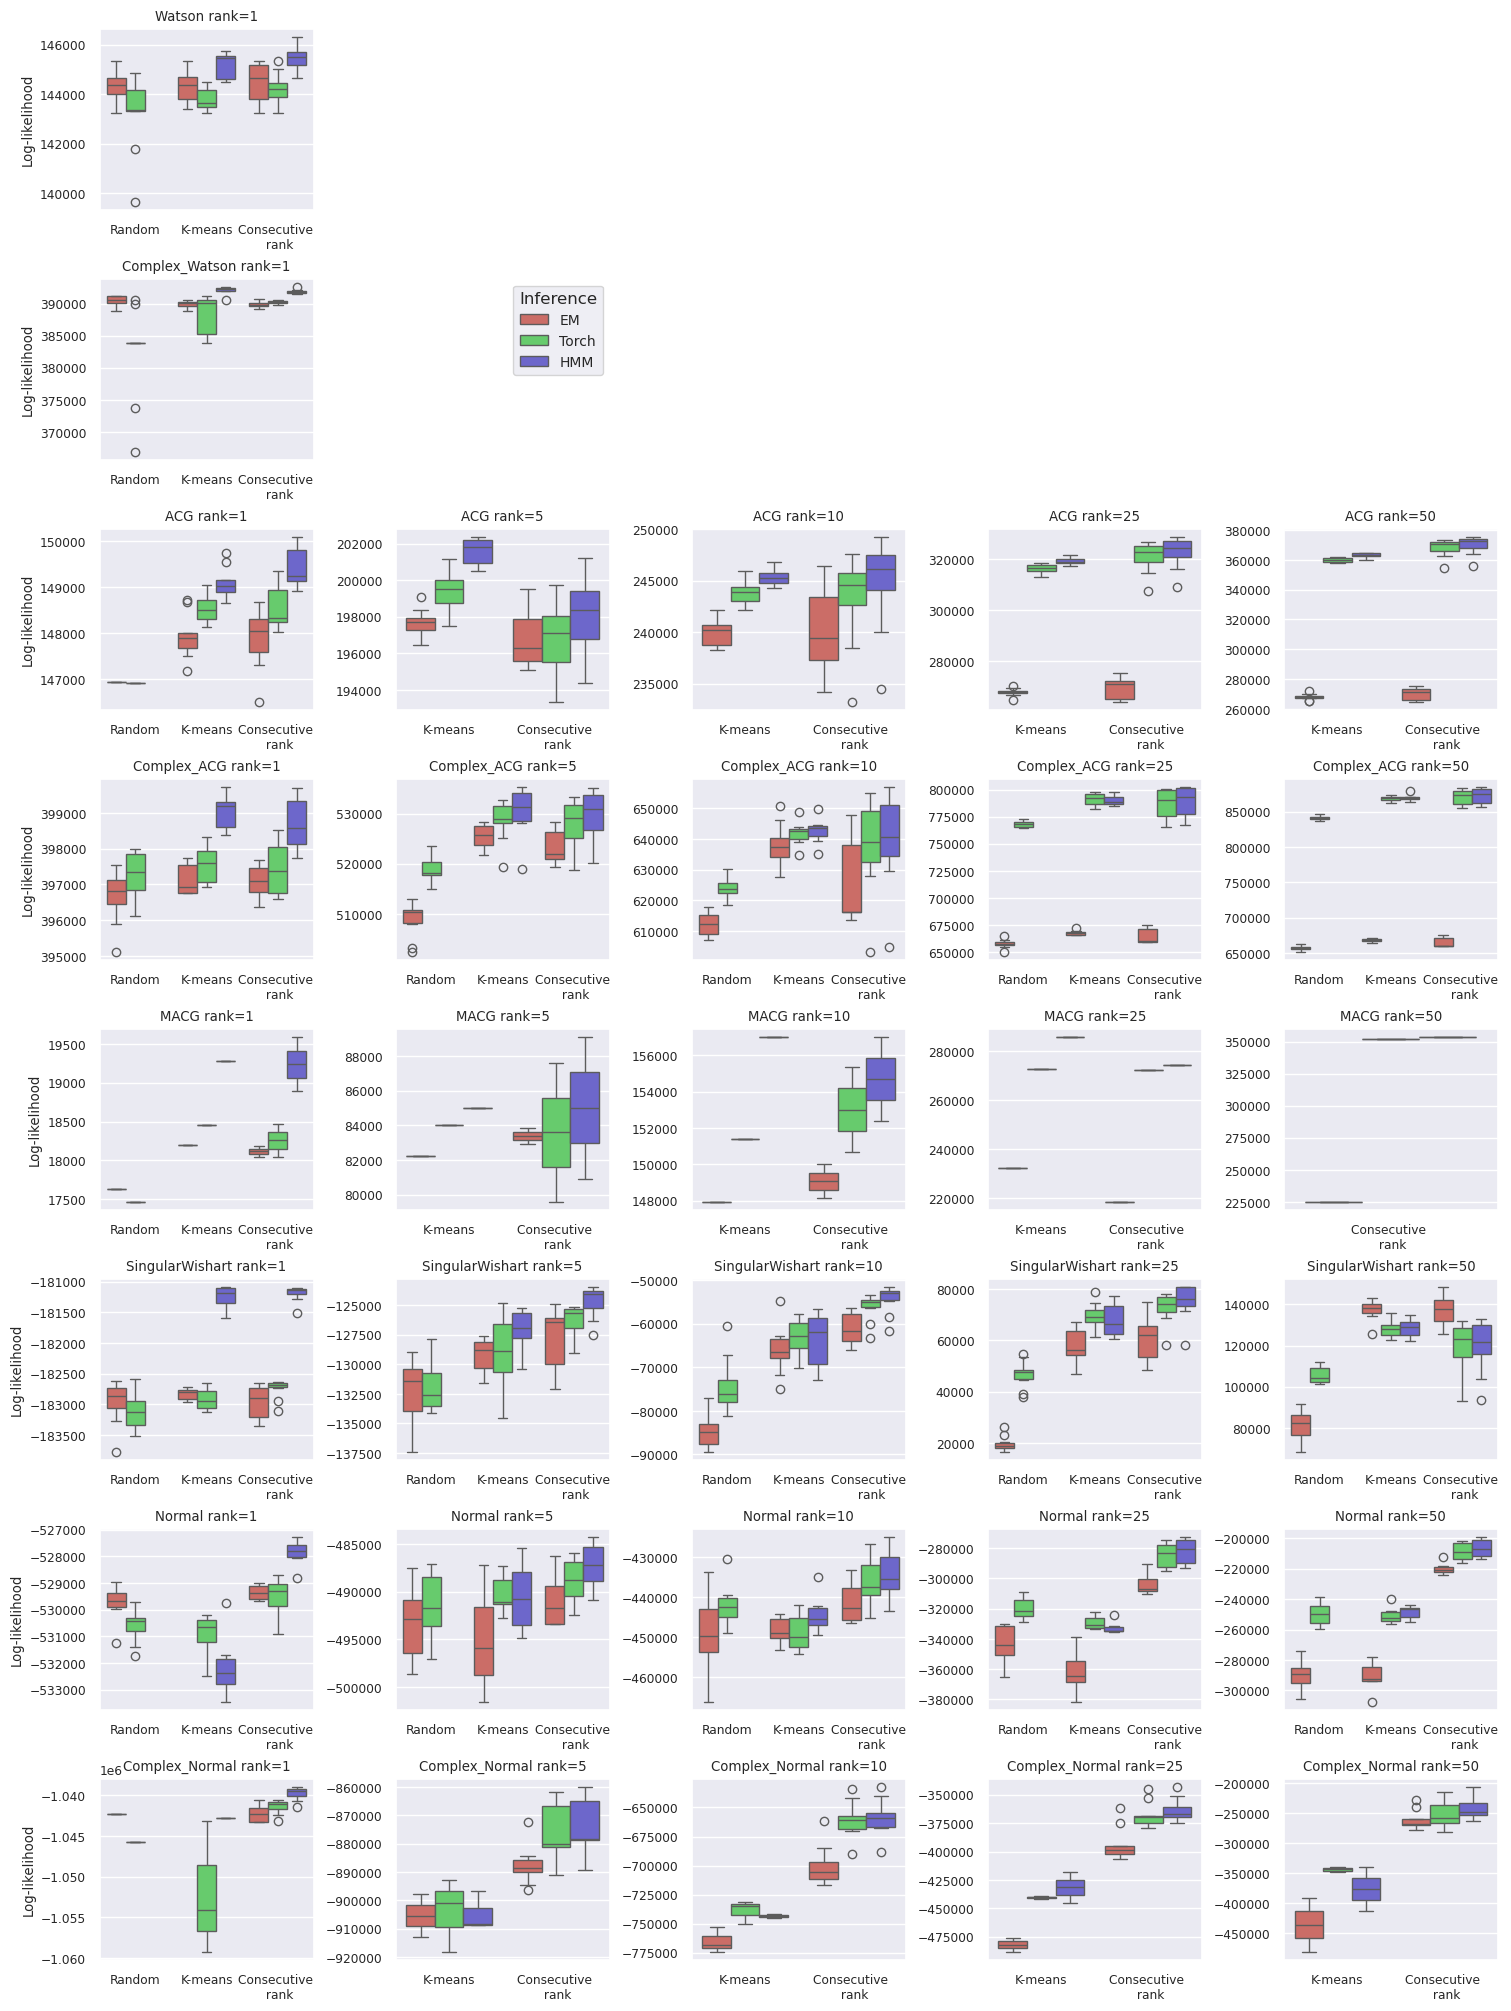

In [7]:
sns.set(font_scale=0.8)
fig,axs = plt.subplots(8,5,figsize=(15,20),layout='constrained')
for i,models in enumerate(['Watson','Complex_Watson','ACG','Complex_ACG','MACG','SingularWishart','Normal','Complex_Normal']):
    for j,rank in enumerate([1,5,10,25,50]):
        if rank!=1 and models in ['Watson','Complex_Watson']:
            axs[i,j].axis('off')
            continue
        df0 = df[df['modelname_old']==models]
        df1 = df0[df0['rank']==rank]
        df1 = df1[df1['initialization']!='Analytical \n maximization']
        sns.boxplot(y='train_loglik', x='initialization',hue='group', data=df1, ax=axs[i,j], palette=palette2)
        axs[i,j].set_title(models+' rank='+str(rank))
        # axs[i,j].set_ylim([0,1])
        if j!=0:
            axs[i,j].set_ylabel('')
        else:
            axs[i,j].set_ylabel('Log-likelihood')
        # if i!=3:
        axs[i,j].set_xlabel('')
        if i==0 and j==0:
            axs[1,1].legend(loc='upper right', fontsize=10, title='Inference', title_fontsize=12, handles=axs[i,j].get_legend_handles_labels()[0], labels=axs[i,j].get_legend_handles_labels()[1])
        axs[i,j].get_legend().remove()
            
        # axs[i,j].set_xticklabels(axs[i,j].get_xticklabels(), rotation=45)
plt.savefig('figures/torchvsEM_phase_narrowband_controlled_results_loglik.pdf', bbox_inches='tight')

/dtu-compute/HCP_dFC/2023/hcp_dfc/PCMM/helper_functions.py:259: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='NMI', y='names2', data=df_fig2, palette=palette_husl2, order=order)


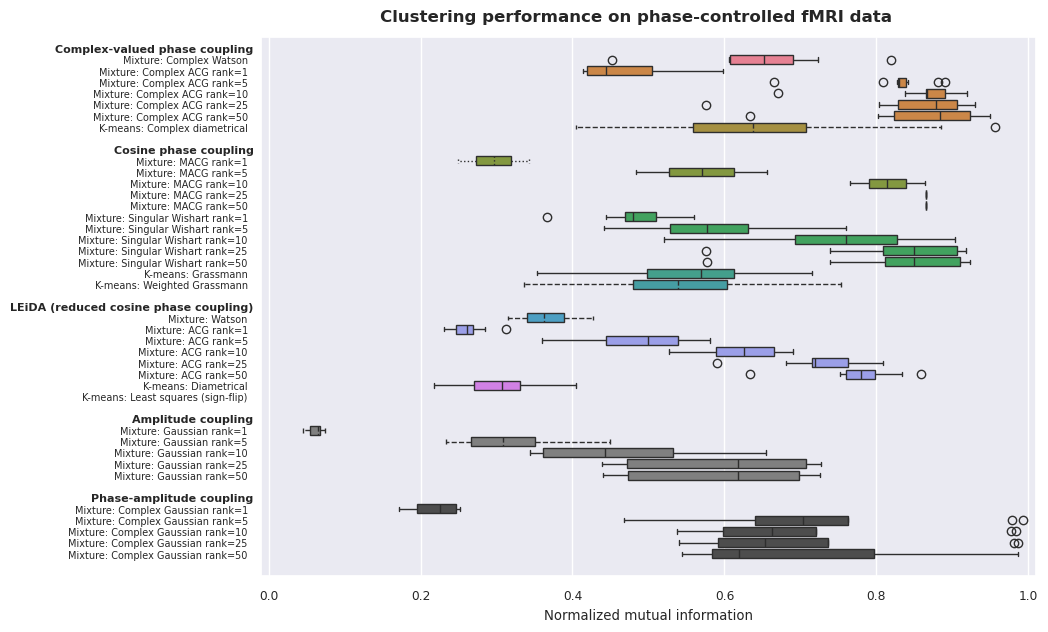

In [ ]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from helper_functions_paper import horizontal_boxplot
df2 = df[df['group']=='Torch']
df2 = df2[df2['initialization']=='Consecutive \n rank']
df_km = df_kmeans[df_kmeans['init_method']=='++']
df_fig = pd.concat([df2,df_km], ignore_index=True)
df_fig['NMI'] = df_fig['train_NMI']
fig = horizontal_boxplot(df_fig,type=1,ranks=[1,5,10,25,50])
# fig.ylim([-2,52])
# in boldface
fig.suptitle('Clustering performance on phase-controlled fMRI data',fontsize=12, fontweight='bold', y=0.92)
fig.savefig('figures/torchvsEM_phase_narrowband_controlled_results_horizontal_boxplot.pdf', bbox_inches='tight')